In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import optuna
from collections import Counter
from tqdm import tqdm

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from catboost import CatBoostClassifier
from sklearn.linear_model import LogisticRegression
from imblearn.ensemble import BalancedRandomForestClassifier, RUSBoostClassifier


import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/corpus-of-russian-news-articles-from-lenta/lenta-ru-news.csv
/kaggle/input/stocks/BSPB.xlsx
/kaggle/input/stocks/VTBR.xlsx
/kaggle/input/stocks/SBER.xlsx
/kaggle/input/sber-price-hist/---.-ru0009029540.xlsx
/kaggle/input/test-to-delete/test.json
/kaggle/input/bankdefaultsinrussia/dataset.csv


# I. Classic ML
*Prediciton of banks' default and its probability*

Goals:
- to analyze how well we can predict default and its probability with classic ML methods
- to use predicted features as part of larger Language Model

## 1. Russian banks' defaults Dataset

In [ ]:
df = pd.read_csv('/kaggle/input/bankdefaultsinrussia/dataset.csv')
df = df.dropna().reset_index(drop=True)
df['дата'] = pd.to_datetime(df['дата'])
df = df.astype({'лицензия': 'int', 'default': 'int', 'msk_spb': 'int'})
df = df.rename(columns={'лицензия': 'licence_num', 'дата': 'date'})

In [ ]:
# metrics
def get_scores(y_hat, y_true, task='classification'):
    pr = precision_score(y_true, y_hat)
    rec = recall_score(y_true, y_hat)
    f1 = f1_score(y_true, y_hat)

    if task == 'classification':
        acc = accuracy_score(y_true, y_hat)
    else:
        acc = None
    return round(pr, 4), round(rec, 4), round(f1, 4), round(acc, 4)

In [ ]:
# feature engineering
df['month'] = df['date'].dt.month
df['year'] = df['date'].dt.year
df['day_of_week'] = pd.DatetimeIndex(df['date']).dayofweek
# df['yearmonth'] = df.apply(lambda row: 100 * row['year'] + row['month'], axis = 1)

df['n_reports'] = df.groupby('licence_num')['licence_num'].transform('count')
df['occurence'] = df.groupby(['licence_num']).cumcount()+1

## 2.1. Default Prediction for single bank based on aggregated data
*- agregating data for every bank during whole period of time presented in dataset and predicting default for certain bank generally*

In [ ]:
df_agg_default = df.groupby('licence_num', as_index=False).agg({'default': 'max'})
df_agg_mean = df.loc[:, ~df.columns.isin(['default'])].groupby('licence_num').mean().merge(df_agg_default, how='left', on='licence_num')
df_agg_last = pd.concat([df.loc[df.default == 1], df.loc[df.default != 1].groupby('licence_num', as_index=False).last()], axis=0)
df_agg_prelast = df.iloc[df.loc[df.default == 1].index - 1]\
                   .merge(df.loc[df.default == 1, ['licence_num', 'default']],
                          how='left', on='licence_num', suffixes=('_old', '')).drop_duplicates().drop(columns=['default_old'])
df_agg_prelast = pd.concat([df_agg_prelast.loc[df_agg_prelast.default.notna()],
                            df.loc[(df.default != 1) & (~df.licence_num.isin(df_agg_prelast.licence_num))]\
                              .groupby('licence_num', as_index=False).nth(-2)], axis=0)

In [ ]:
# features
target_feature = 'default'
exclude_features = ['licence_num', 'date', target_feature]
model_features = np.setdiff1d(df.columns.to_numpy(), np.array(exclude_features))
cat_features = ['msk_spb']
numeric_features = np.setdiff1d(df.columns.to_numpy(), np.array([*exclude_features, *cat_features]))

# models
model_lr = LogisticRegression(random_state=73, verbose=False, n_jobs=-1)
model_rf = RandomForestClassifier(random_state=74, verbose=False, n_jobs=-1)
model_cb = CatBoostClassifier(random_seed=75, verbose=0)
models_dict = {'LogisticRegression': {'model': model_lr, 'result': []},
               'RandomForestClassifier': {'model': model_rf, 'result': []},
               'CatBoostClassifier': {'model': model_cb, 'result': []}}

# fitting + predicting for every data and model
for key in tqdm(models_dict.keys()):
    res = []

    for data in tqdm([df_agg_mean, df_agg_last, df_agg_prelast]):
        # data
        X = data[model_features]
        y = data[target_feature]
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=11, stratify=y)
        model = models_dict[key]['model']

        # pipeline
        pipe = Pipeline([
            ('preprocessing_', ColumnTransformer([
                ('num_preproc', StandardScaler(), numeric_features),
                ('cat_preproc', OneHotEncoder(handle_unknown='ignore', sparse_output=False), cat_features)
            ])),
            ('model_', model)
        ])

        # fit
        pipe.fit(X_train, y_train)

        # prediction
        y_pred = pipe.predict(X_test)
        metrics = get_scores(y_pred, y_test)
        res.append(metrics)

    models_dict[key]['result'] = res

100%|██████████| 3/3 [00:23<00:00,  7.93s/it]


In [ ]:
index = pd.MultiIndex.from_arrays([[*['LogisticRegression'] * 4, *['RandomForestClassifier'] * 4, *['CatBoostClassifier'] * 4],
                                   ['precision', 'recall', 'f1-score', 'accuracy'] * 3],
                                  names=['model', 'metric'])

result_default_prediction = \
    pd.DataFrame({'mean': np.array([models_dict[key]['result'] for key in models_dict.keys()])[0, :, :].flatten(),
                  'last': np.array([models_dict[key]['result'] for key in models_dict.keys()])[1, :, :].flatten(),
                  'prelast': np.array([models_dict[key]['result'] for key in models_dict.keys()])[2, :, :].flatten()},
                 index=index)

result_default_prediction

mean    last  prelast
model                  metric                            
LogisticRegression     precision  0.6182  0.7442   0.6964
                       recall     0.5231  0.4923   0.6000
                       f1-score   0.5667  0.5926   0.6446
                       accuracy   0.7426  0.7822   0.7871
RandomForestClassifier precision  0.9853  0.9206   0.9692
                       recall     0.8933  0.7733   0.8400
                       f1-score   0.9371  0.8406   0.9000
                       accuracy   0.9674  0.9203   0.9493
CatBoostClassifier     precision  0.9714  0.8333   0.9857
                       recall     0.9189  0.8108   0.9324
                       f1-score   0.9444  0.8219   0.9583
                       accuracy   0.9619  0.8762   0.9714

* columns' names: data aggregation type of every bank - `mean, last, prelast`

## 2.2. Default Prediction Models for every period
*- if certain bank default in certain period of time*

In [ ]:
# features
target_feature = 'default'
exclude_features = ['licence_num', 'date', target_feature]
model_features = np.setdiff1d(df.columns.to_numpy(), np.array(exclude_features))
cat_features = ['msk_spb']
numeric_features = np.setdiff1d(df.columns.to_numpy(), np.array([*exclude_features, *cat_features]))

# data
y = df[target_feature]
X = df[model_features]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=9, stratify=y)

# models
model_lr = LogisticRegression(solver='newton-cg', class_weight='balanced', random_state=4, n_jobs=-1)
model_rf = BalancedRandomForestClassifier(random_state=42, n_estimators=200)
model_svc = SVC(class_weight='balanced', probability=False)
model_boost = RUSBoostClassifier(n_estimators=200, algorithm='SAMME.R', random_state=0)
model_cb = CatBoostClassifier(random_seed=7, verbose=100,
                              class_weights=dict(
                                  zip(
                                      np.unique(y_train),
                                      compute_class_weight(
                                          class_weight='balanced', classes=np.unique(y_train), y=y_train)
                                  )
                              ))
models_dict = {'LogisticRegression': {'result': [], 'model': model_lr},
               'RandomForestClassifier': {'result': [], 'model': model_rf},
               'SVC': {'result': [], 'model': model_svc},
               'RUSBoostClassifier': {'result': [], 'model': model_boost},
               'CatBoostClassifier': {'result': [], 'model': model_cb}}

# fitting + predicting for every model
for key in tqdm(models_dict.keys()):
    model = models_dict[key]['model']

    # pipeline
    pipe = Pipeline([
        ('preprocessing_', ColumnTransformer([
            ('num_preproc', StandardScaler(), numeric_features),
            ('cat_preproc', OneHotEncoder(handle_unknown='ignore', sparse_output=False), cat_features)
        ])),
        ('model_', model)
    ])

    # fit
    pipe.fit(X_train, y_train)

    # prediction
    y_pred = pipe.predict(X_test)
    metrics = get_scores(y_pred, y_test)
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
    num_def, num_not_def, num_all = y_test.value_counts()[1], y_test.value_counts()[0], len(y_test)

    models_dict[key]['result'] = [*list(metrics), tn, fp, fn, tp,
                                  num_def, num_not_def, num_all]

 20%|██        | 1/5 [00:06<00:25,  6.35s/it]/opt/conda/lib/python3.10/site-packages/imblearn/ensemble/_forest.py:576: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/opt/conda/lib/python3.10/site-packages/imblearn/ensemble/_forest.py:588: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(
/opt/conda/lib/python3.10/site-packages/imblearn/ensemble/_forest.py:600: FutureWarning: The default of `bootstrap` will change from `True` to `False` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `False` to silence this warning and adopt the futu

Learning rate set to 0.060607
0:	learn: 0.6700242	total: 86.8ms	remaining: 1m 26s
100:	learn: 0.2561439	total: 2.45s	remaining: 21.8s
200:	learn: 0.1331722	total: 4.84s	remaining: 19.2s
300:	learn: 0.0662356	total: 7.19s	remaining: 16.7s
400:	learn: 0.0359847	total: 9.41s	remaining: 14.1s
500:	learn: 0.0219141	total: 11.6s	remaining: 11.6s
600:	learn: 0.0143834	total: 14.3s	remaining: 9.5s
700:	learn: 0.0099680	total: 16.5s	remaining: 7.03s
800:	learn: 0.0070799	total: 18.7s	remaining: 4.65s
900:	learn: 0.0052805	total: 20.9s	remaining: 2.29s
999:	learn: 0.0043142	total: 23s	remaining: 0us


100%|██████████| 5/5 [04:09<00:00, 49.92s/it]


In [ ]:
result_default_period_prediction = \
    pd.DataFrame({key: models_dict[key]['result'] for key in models_dict.keys()},
                 index=['precision', 'recall', 'f1-score', 'accuracy',
                        'TrueNegative', 'FalsePositive', 'FalseNegative', 'TruePositive',
                        'Number of Positive (default)', 'Number of Negative (not default)',
                        'Total Number'])

result_default_period_prediction

,LogisticRegression,RandomForestClassifier,SVC,RUSBoostClassifier,CatBoostClassifier
precision,0.0122,0.0182,0.0099,0.0148,0.1176
recall,0.6486,0.8378,0.2432,0.4054,0.0541
f1-score,0.0240,0.0356,0.0190,0.0285,0.0741
accuracy,0.7234,0.7617,0.8685,0.8550,0.9929
TrueNegative,5075.0000,5338.0000,6113.0000,6012.0000,6997.0000
FalsePositive,1937.0000,1674.0000,899.0000,1000.0000,15.0000
FalseNegative,13.0000,6.0000,28.0000,22.0000,35.0000
TruePositive,24.0000,31.0000,9.0000,15.0000,2.0000
Number of Positive (default),37.0000,37.0000,37.0000,37.0000,37.0000
Number of Negative (not default),7012.0000,7012.0000,7012.0000,7012.0000,7012.0000


In [ ]:
# transformation to Regression task to predict probability of default - to be added...

*Conclusion:*

- To simpify this part I just stopped at CatBoost model that has quite good quality.
- It can identify quite well default with aggregated data based on lifetime data of bank or with timelag in 1 month
- conclusions about prediction of default period in P.S.

## P.S. Imbalanced classes' weigths optimization for 2.2.

Fitting 5 folds for each of 10 candidates, totalling 50 fits


/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


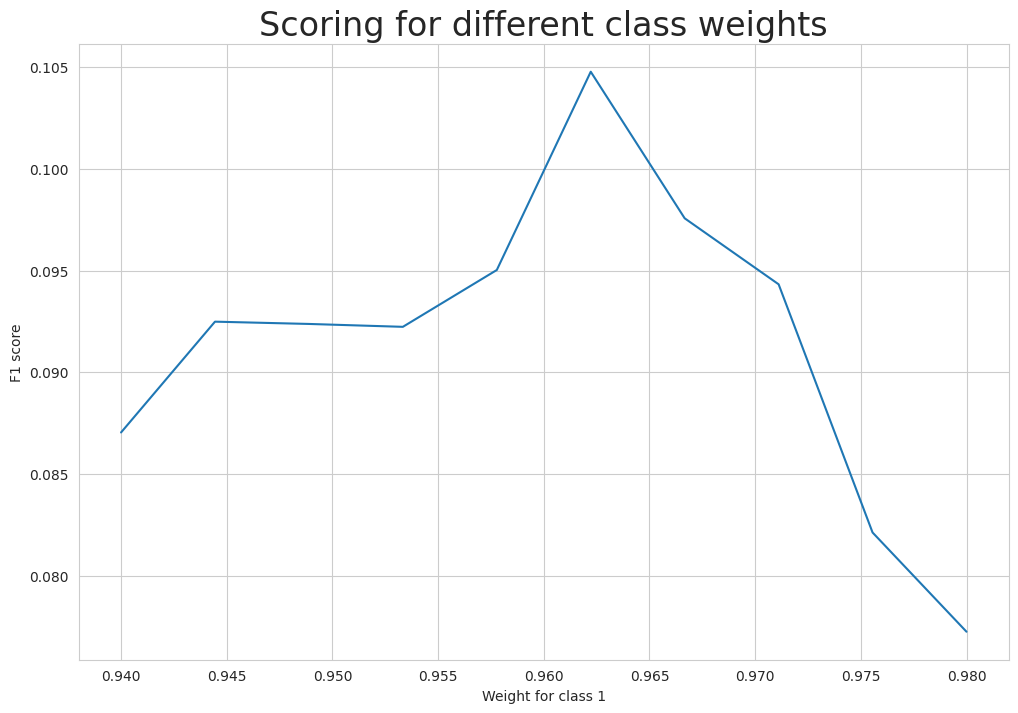

In [ ]:
lr = LogisticRegression(solver='newton-cg')
X_tr = pipe['preprocessing_'].fit_transform(X_train)

#Setting the range for class weights
weights = np.linspace(0.02, 0.06, 10)  # interval was chosen after long gridsearching from 0 to 0.99

#Creating a dictionary grid for grid search
param_grid = {'class_weight': [{0: x, 1: 1.0-x} for x in weights]}

#Fitting grid search to the train data with 5 folds
gridsearch = GridSearchCV(estimator=lr,
                          param_grid= param_grid,
                          cv=StratifiedKFold(),
                          n_jobs=-1,
                          scoring='f1',
                          verbose=2).fit(X_tr, y_train)

# Ploting the score for different values of weight
sns.set_style('whitegrid')
plt.figure(figsize=(12, 8))
weigh_data = pd.DataFrame({'score': gridsearch.cv_results_['mean_test_score'], 'weight': (1- weights)})
sns.lineplot(data=weigh_data, x='weight', y='score')
plt.xlabel('Weight for class 1')
plt.ylabel('F1 score')
plt.title('Scoring for different class weights', fontsize=24)
plt.show();

In [ ]:
# model
weight_of_zero_class = weights[gridsearch.cv_results_['mean_test_score'].argmax()]
model0 = LogisticRegression(solver='newton-cg', class_weight={0: weight_of_zero_class, 1: (1-weight_of_zero_class)})

# pipeline
pipe = Pipeline([
    ('preprocessing_', ColumnTransformer([
        ('num_preproc', StandardScaler(), numeric_features),
        ('cat_preproc', OneHotEncoder(handle_unknown='ignore', sparse_output=False), cat_features)
    ])),
    ('model_', model0)
])

pipe.fit(X_train, y_train)

# prediction
y_pred = pipe.predict(X_test)
metrics = get_scores(y_pred, y_test)
tn, fp, fn, tp = confusion_matrix(y_test, y_pred).flatten()
num_def, num_not_def, num_all = y_test.value_counts()[1], y_test.value_counts()[0], len(y_test)

result_default_period_prediction = pd.concat([
    result_default_period_prediction,
    pd.DataFrame({'LR w/t weights tuned': [*list(metrics), tn, fp, fn, tp,
                                           num_def, num_not_def, num_all]},
                 index=['precision', 'recall', 'f1-score', 'accuracy',
                        'TrueNegative', 'FalsePositive', 'FalseNegative', 'TruePositive',
                        'Number of Positive (default)', 'Number of Negative (not default)',
                        'Total Number'])], axis=1)

result_default_period_prediction

,LogisticRegression,RandomForestClassifier,SVC,RUSBoostClassifier,CatBoostClassifier,LR w/t weights tuned
precision,0.0122,0.0182,0.0099,0.0148,0.1176,0.1053
recall,0.6486,0.8378,0.2432,0.4054,0.0541,0.1081
f1-score,0.0240,0.0356,0.0190,0.0285,0.0741,0.1067
accuracy,0.7234,0.7617,0.8685,0.8550,0.9929,0.9905
TrueNegative,5075.0000,5338.0000,6113.0000,6012.0000,6997.0000,6978.0000
FalsePositive,1937.0000,1674.0000,899.0000,1000.0000,15.0000,34.0000
FalseNegative,13.0000,6.0000,28.0000,22.0000,35.0000,33.0000
TruePositive,24.0000,31.0000,9.0000,15.0000,2.0000,4.0000
Number of Positive (default),37.0000,37.0000,37.0000,37.0000,37.0000,37.0000
Number of Negative (not default),7012.0000,7012.0000,7012.0000,7012.0000,7012.0000,7012.0000


* no remarkable improvement of rare class detection
* even number of TruePositive become lower
* but, however, there is no tendency to consider every period as default for bank that will have default whenever in future or make defaulted every bank (so number of FalsePositive is lower)
* so, it might bring some profit but need more proper work for parameters

*so I decided to remain 'balanced' hyperparameter instead of manual weigths*

*and use aggregated data and model based on this data to predict potential default*


## P.S.S. (to be continued...) Hyperparameter optimization for 2.1.

*-Decided to find the best hyperparameters for CatBoost, because its results of the model showed best metrics for period before and at the time of default*

In [ ]:
# features
target_feature = 'default'
exclude_features = ['licence_num', 'date', target_feature]
model_features = np.setdiff1d(df.columns.to_numpy(), np.array(exclude_features))
cat_features = ['msk_spb']
numeric_features = np.setdiff1d(df.columns.to_numpy(), np.array([*exclude_features, *cat_features]))

# models
model_cb = CatBoostClassifier(random_seed=75, verbose=0, iterations=3000)

# fitting + predicting for every data and model
for data in tqdm([df_agg_mean, df_agg_last, df_agg_prelast]):
    # data
    data = data.astype({'year': 'int', 'month': 'int', 'msk_spb': 'int', 'day_of_week': 'int'})
    X = data[model_features]
    y = data[target_feature]
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=11, stratify=y)

    # fit
    scaler = StandardScaler()
    X_train[numeric_features] = scaler.fit_transform(X_train[numeric_features])
    X_test[numeric_features] = scaler.fit_transform(X_test[numeric_features])

    def objective(trial):
        params = {
            "iterations": 1000,
            'task_type': 'GPU',
            'bootstrap_type': 'Poisson',
            "learning_rate": trial.suggest_float("learning_rate", 1e-3, 0.1, log=True),
            "depth": trial.suggest_int("depth", 1, 10),
            "subsample": trial.suggest_float("subsample", 0.05, 1.0),
            "min_data_in_leaf": trial.suggest_int("min_data_in_leaf", 1, 100),
        }

        model = CatBoostClassifier(**params, silent=True, random_seed=75)
        model.fit(X_train, y_train)

        y_pred = model.predict(X_test)
        accuracy = accuracy_score(y_test, y_pred)

        return accuracy

    def detailed_objective(trial):
        params = {
            "iterations": 1000,
            'task_type': 'GPU',
            'bootstrap_type': 'Poisson',
            "learning_rate": trial.suggest_float("learning_rate", 1e-3, 0.1, log=True),
            "depth": trial.suggest_int("depth", 1, 10),
            "subsample": trial.suggest_float("subsample", 0.05, 1.0),
            "min_data_in_leaf": trial.suggest_int("min_data_in_leaf", 1, 100)
        }

        model = CatBoostClassifier(**params, silent=True, random_seed=75)
        model.fit(X_train, y_train)

        y_pred = model.predict(X_test)
        accuracy = accuracy_score(y_test, y_pred).round(4)
        recall = recall_score(y_test, y_pred).round(4)
        precision = precision_score(y_test, y_pred).round(4)
        f1 = f1_score(y_test, y_pred).round(4)

        return precision, recall, f1, accuracy

    study = optuna.create_study(direction='maximize')
    study.optimize(objective, n_trials=20)

    # set results after optuna
    models_dict['CatBoostClassifier']['result'].append(detailed_objective(study.best_trial))

  0%|          | 0/3 [00:00<?, ?it/s][I 2024-05-22 11:03:27,510] A new study created in memory with name: no-name-7cfe4488-6812-4dad-9c1c-acce5322eb10
[I 2024-05-22 11:03:45,118] Trial 0 finished with value: 0.7326732673267327 and parameters: {'learning_rate': 0.0011723497760087159, 'depth': 5, 'subsample': 0.9012507305758303, 'min_data_in_leaf': 88}. Best is trial 0 with value: 0.7326732673267327.
[I 2024-05-22 11:03:59,011] Trial 1 finished with value: 0.5247524752475248 and parameters: {'learning_rate': 0.06149175110416532, 'depth': 2, 'subsample': 0.5344588567457024, 'min_data_in_leaf': 25}. Best is trial 0 with value: 0.7326732673267327.
[I 2024-05-22 11:04:33,302] Trial 2 finished with value: 0.6485148514851485 and parameters: {'learning_rate': 0.06756924971714114, 'depth': 7, 'subsample': 0.43214123480661254, 'min_data_in_leaf': 43}. Best is trial 0 with value: 0.7326732673267327.
[I 2024-05-22 11:05:30,184] Trial 3 finished with value: 0.6831683168316832 and parameters: {'learn

In [ ]:
index = pd.MultiIndex.from_arrays([[*['LogisticRegression'] * 4, *['RandomForestClassifier'] * 4, *['CatBoostClassifier'] * 4],
                                   ['precision', 'recall', 'f1-score', 'accuracy'] * 3],
                                  names=['model', 'metric'])

result_default_prediction = \
    pd.DataFrame({'mean': np.array([models_dict[key]['result'] for key in models_dict.keys()])[0, :, :].flatten(),
                  'last': np.array([models_dict[key]['result'] for key in models_dict.keys()])[1, :, :].flatten(),
                  'prelast': np.array([models_dict[key]['result'] for key in models_dict.keys()])[2, :, :].flatten()},
                 index=index)

result_default_prediction

mean    last  prelast
model                  metric                            
LogisticRegression     precision  0.6182  0.7442   0.6964
                       recall     0.5231  0.4923   0.6000
                       f1-score   0.5667  0.5926   0.6446
                       accuracy   0.7426  0.7822   0.7871
RandomForestClassifier precision  0.9853  0.9206   0.9692
                       recall     0.8933  0.7733   0.8400
                       f1-score   0.9371  0.8406   0.9000
                       accuracy   0.9674  0.9203   0.9493
CatBoostClassifier     precision  0.9714  0.8333   0.9857
                       recall     0.9189  0.8108   0.9324
                       f1-score   0.9444  0.8219   0.9583
                       accuracy   0.9619  0.8762   0.9714

* no improvement after optuna

## P.S.S.S. Oversampling
*-no improvement was detected (guess because no-default class significantly prevails default class)*

In [ ]:
from imblearn.over_sampling import RandomOverSampler, SMOTE

y_train0 = y_train.copy()

ros = RandomOverSampler(random_state=42)
smote = SMOTE()

# fit predictor and target variable
# X_train, y_train = ros.fit_resample(X_train, y_train)
X_train, y_train = smote.fit_resample(X_train, y_train)

print('Original dataset shape', Counter(y_train0))
print('Resample dataset shape', Counter(y_train))

Original dataset shape Counter({0: 63098, 1: 336})
Resample dataset shape Counter({0: 63098, 1: 63098})
